# Intro #
Refer to the famous Dogs and Cats classification problem. Goal is simple: we need to teach machine distinguish dogs from cats. In this notebook we will try to address it by using neural networks.

**General plan**:  
1.Explore dataset, make some preprocessing if need.   
2.Choose two different neural network types, implement and train it on validation and train data.  
3.Make predictions on test data.  
4.Outline conclusions.

**Why neural networks?**  
They have proven themselves in practice of real-word problem solving and competitions, in particular in
computer vision problem. Thus, Сonvolution Neural Networks (CNN) perfectly proved themselves especially in matters of computer vision. Many CNN architectures were specially designed for that purpose. An overview of CNN concepts, their architectures and implementations is beyond the scope of this article. We will choose two of them, give short overview and describe in detail their implementation and training. The rationale for their choice is given in the Machining Learning section.

**Some comments**  
We have reviewed many laptops on this topic, the authors of which have done a great job, for which many thanks can be given to them. But unfortunately, many authors paid little attention to the comments of their actions, and also did not highlight such subtleties as loading datasets, unzipping them, connecting external weights. In the process of this work, we were faced with many nuances and glitches in these "auxiliary", but inevitable issues. Therefore, we tried to comment on almost every action, in particular, on "auxiliary" issues. So some comments with direct links to Stack Overflow may be found in text.

# Import libraries and tools #

In [1]:
# Import libraries and tools
# Data preprocessing and linear algebra
import os, re, random
import pandas as pd
import numpy as np
import zipfile
np.random.seed(2)

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# Tools for cross-validation, error calculation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical

# Machine Learning
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, Activation
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import optimizers
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


First, lets outline our goal. "Our goal is to correctly distinguish dogs from cats."

# Data load #

### Load and unzip data ###

Since we created notebook from "Dogs vs Cats" page, data will load automatically and may be found in /input directory after session starts.

In [2]:
# Save datasets path
PATH = "../input/dogs-vs-cats-redux-kernels-edition"
PATH_TRAIN = "train_images/"
PATH_TEST = "test_images/"

In [3]:
# Check datasets in file system
os.listdir(PATH)

['sample_submission.csv', 'test.zip', 'train.zip']

In [4]:
# Save archives paths and names
train_image_path = os.path.join(PATH, "train.zip")
test_image_path = os.path.join(PATH, "test.zip")

In [5]:
# Create subfolder for train dataset
# Disclaimer. It is need because ImageDataGenerator() which we will use later correctly reads images only from subfolders
os.mkdir('/kaggle/working/train_images')

In [6]:
# Create subfolder for test dataset
os.mkdir('/kaggle/working/test_images')

In [7]:
# Unzip train dataset
archive = zipfile.ZipFile(train_image_path,"r")
for file in archive.namelist():
        archive.extract(file, 'train_images/')

In [8]:
# Unzip test dataset
archive = zipfile.ZipFile(test_image_path,"r")
for file in archive.namelist():
        archive.extract(file, 'test_images/')

In [9]:
# Check if our kittens and puppies are in right place
# os.listdir('/kaggle/working/train_images/train')

In [10]:
# If you prefer work with file system, unzip can be done using bash commands.
# Just leave this code here, it will give same result - unzipped images in two folders.
# Unzip train dataset
# !unzip ../input/dogs-vs-cats-redux-kernels-edition/train.zip
# Check unzipped dataset in file system
#! ls -l train/
# Unzip test dataset
# !unzip ../input/dogs-vs-cats-redux-kernels-edition/test.zip

# Data exploration #

### Save data to NumPy and Pandas arrays ###

We begin with some small preparations. We should extract our images filemames and labels. They will be used in model training.  
**Note**. For now we will not work with test data in order to prevent mistakenly using it instead of validation.
As we know, test data must be shown to algorhytm only once - at final prediction. So, we will work on test subset at pre-final - prediction step.

In [11]:
# Save images names to variable
train_images = os.listdir(f'{PATH_TRAIN}/train/')

In [12]:
# Then extract images names and save them into Numpy array
imagenames = np.array([f'{f}' for f in train_images])

In [13]:
# Check our image names array
imagenames

array(['dog.3710.jpg', 'cat.1553.jpg', 'cat.10925.jpg', ...,
       'cat.6843.jpg', 'cat.8448.jpg', 'cat.9228.jpg'], dtype='<U13')

In [14]:
# Assign labels to images according to competitions task (0-cat, 1-dog)
# Implement array of image categories
categories = []
for imagename in imagenames:
    # Loop through data and split our images names
    split_category = imagename.split('.')[0]
    # Assign labels
    if split_category == 'cat':
        categories.append(str(0))
    else:
        categories.append(str(1))

In [15]:
# Save our filenames 
animals = pd.DataFrame({
    'Image name': imagenames,
    'Category': categories
})
animals.head(5)

,Image name,Category
0,dog.3710.jpg,1
1,cat.1553.jpg,0
2,cat.10925.jpg,0
3,cat.4296.jpg,0
4,dog.12303.jpg,1


In [16]:
# Check total amount of 0 and 1 labels
animals['Category'].value_counts()

1    12500
0    12500
Name: Category, dtype: int64

As we see, our tasks initial 12500 images dataset is balanced: both 12500 dogs and cats. Good.  
Ok. Now we can take a look at one little cute kitten.

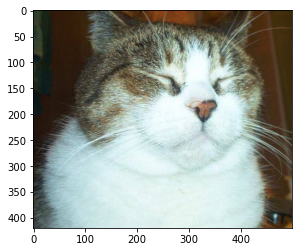

In [109]:
# Draw a cat
# Don't forget to install 'pillow' module (conda install pillow) to give a 'pyplot' ability of working with '.jpg'
img = plt.imread(f'{PATH_TRAIN}/train/{imagenames[1]}')
plt.imshow(img);

Isn't it pretty? Our efforts were not in vain. Move on.

### Split data on train and validation subsets ###

In [18]:
# Split data on train and validation subsets
# Using 10% or 20% from train data is classical approach
X_train, X_val = train_test_split(animals, test_size=0.2,  random_state=2)
X_train = X_train.reset_index()
X_val = X_val.reset_index()

# We may want use only 1800 images because of CPU computational reasons. If so, this code should be run
# X_train = X_train.sample(n=1800).reset_index()
# X_val = X_val.sample(n=100).reset_index()

Count amount of rows. Need for two reasons.  
First: will be used in model fit process as parameter devided by batch size.  
Second: if we cut 1800-images subset for comp. reasons we should check if there are exact 1800
images present.

In [19]:
# Count
total_X_train = X_train.shape[0]
total_X_val = X_val.shape[0]

In [20]:
total_X_train

20000

In [21]:
total_X_val

5000

# Machine learning #

In the problems of image recognition, when we get to the part of machine learning itself, question No. 1 arises.  

**Which neural network to choose?**  
Well, we know from the literature that convolutional network architecture is suitable for this task. Already good. But which architecture to choose, because there are dozens of them? Or may be we need to build our own - of course, empirically?  
Truth be sayed, if we study the comparison of models in terms of accuracy and consumed computing power, for example [3], then it becomes clear that the vast majority of architects at one time won various competitions for image recognition. Almost any of them will suit us.

We proceed as follows.  
Based on a comparison of networks [3], lets choose two architectures: **VGG16** and **Resnet-50**.  
Why them?    
Both are famous enough, both have approximately the same accuracy. But they need different computing power: VGG16 requires significantly more.   
We will choose them for comparison.

We will use Transfer Learning (TL).  
It is a paradigm in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.
The essence of the TL is that when we build a network, we import the weights of the same network trained on a very large dataset. thus, we save time and resources.

## Model 1. VGG16 ##

### Description ###

VGG16 [2] CNN architectire proposed in 2014 by K. Simonyan and A. Zisserman (University of Oxford) in their paper “Very Deep Convolutional Networks for Large-Scale Image Recognition” [5]. The model achieves 92.7% top-5 test accuracy in ImageNet - a dataset of over 14 million images belonging to 1000 classes.
Its principal scheme [2] is shown below:

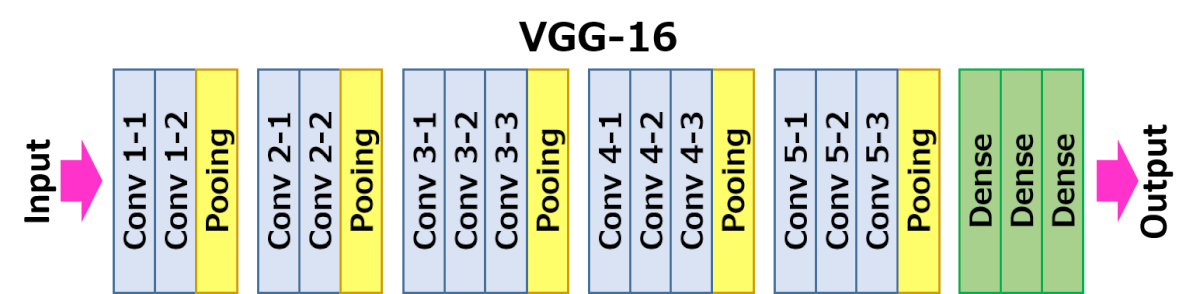

As we can see, this network consists of 16 layers, which are:   
- 13 stacked Convolutional layers;
- 3 Dense layers.

Convolution layers extract features from the image, fully connected layers classify the image using extracted features.  
The number of filters in the convolution layers follow an increasing pattern.  
The informative features are obtained by Maxpooling layers applied at different steps in the architecture.
The dense layers comprises of 4096, 4096, and 1000 nodes each.  
Models full configuration table may be found in [2].

The choice of this model is made due to its provenness and ease of implementation. But, it should be noted that this model, as we have already said, consumes a lot of resources, in other words, it works very slowly. However, the Keras library has a **pre-trained** model that will allow us to save our time and resources. And, as we know, time is money.

Lets proceed with importing and implementation of our pre-trained model.

### Implementation ###

In [22]:
# By default, the VGG16 model expects images as input with the size 224 x 224 pixels with 3 channels (e.g. color).
image_size = 224
input_shape = (image_size, image_size, 3)

In [23]:
# Define CNN model constants
epochs = 5
batch_size = 16

A good VGG16 implementtaion (including pre-trained weights) is present in [4]. We can refer to it for example, or just import model from Keras libs (imported in notebooks libraries section).

In [24]:
# Define our pre-trained model
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

58892288/58889256 [==============================] - 1s 0us/step


In [25]:
# Print models summary table
# Note that it expects input pictures in 224 size and 3 channels, as we mensioned before. So we didn't lie.
print(pre_trained_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [26]:
# Use this if want to see a Big Bang. Downloads VGG16 with total defaults (Total params: 138,357,544).
# Very huge.
# model = VGG16()
# print(model.summary())

In [27]:
# Add some micro-tuning 
# Set above layers to be not traianble since using pre-trained model - they are already trained
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

# Specify networks output    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to one dimension
x = GlobalMaxPooling2D()(last_output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Form our model
model_mod = Model(pre_trained_model.input, x)

In [28]:
# Compile model
model_mod.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy']
                 )

Choosing models hyperparameters (as well as their tuning) is almost empyrical process. In addition, it should be noted that it is a kind of "cherry on the cake" ie performed at the very end of the construction, validation and use of the working model. Therefore, we will for now set the above parameters based on the fact that their combination is known and has proven itself well. After building the model and testing it, we can easily return to this point and tune them if necessary.

### Training DataGenerator ###

Keras has very useful tools for images preprocessing (i.e. rotation, flip, crop, resize etc). Lets use one of them - **ImageDataGenerator** class and perform some actions which are actually almost standard.

In [29]:
# Implement train ImageDataGenerator and specify some small preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [30]:
# Upload images from file system using flow_from_dataframe() method and use our datagen
# to make parallel preprocessing. We obtain uploaded and preprocessed images.
train_generator = train_datagen.flow_from_dataframe(
    X_train, 
    "/kaggle/working/train_images/train",
    x_col='Image name',
    y_col='Category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    #validate_filenames = False
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation DataGenerator ###

In [31]:
# Implement validation ImageDataGenerator
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [32]:
# Upload and peprocess images
validation_generator = validation_datagen.flow_from_dataframe(
    X_val, 
    "/kaggle/working/train_images/train",
    x_col='Image name',
    y_col='Category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    #validate_filenames = False
)

Found 5000 validated image filenames belonging to 2 classes.


In [33]:
# Check one sample generated image
# Create generator for test sample image
generated_example_df = X_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    generated_example_df, 
    "/kaggle/working/train_images/train", 
    x_col='Image name',
    y_col='Category',
    class_mode='categorical',
    #validate_filenames = False
)

Found 1 validated image filenames belonging to 1 classes.


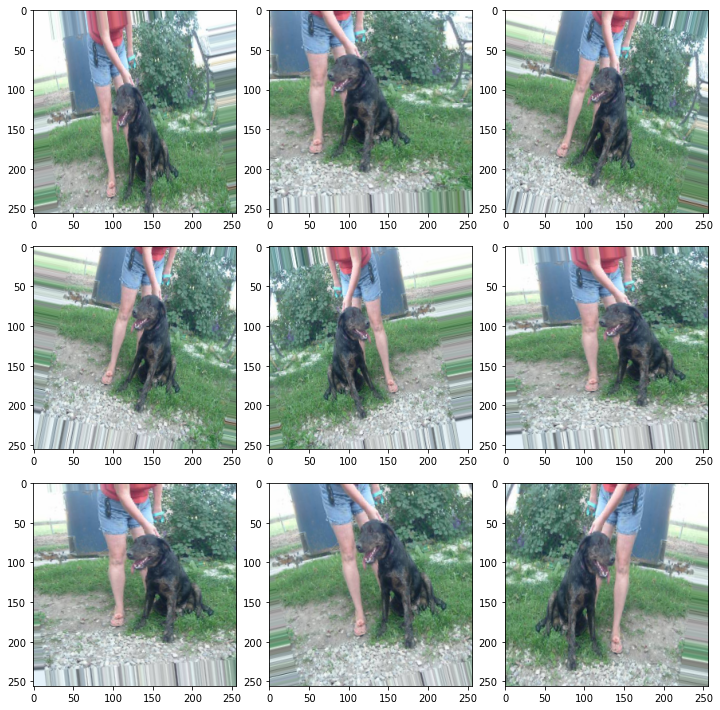

In [34]:
# Plot sample
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Callbacks ###

Before we start teaching our model we should care about avoiding of model overfitting. In general, such techniques are known as **Callbacks**. There are two useful ones: **early stop** and **learning rate reduction**.  
If we cut from our 12500 dataset a small 1800 part, we probably will not fall in overfitting,
but for general purpose lets take care about it.  
**Nota Bene**  
In Kaggle enviroment we should import EarlyStop and ReduceLROnPlateau from tensorflow.keras.callbacks, not from keras.callbacks, since the last doesn't accepted in model.fit(). What shold we do without StackOverflow?

#### Early Stop ####
To prevent overfitting lets stop model learning after 10 epochs when val_loss value not decreased. Lets use EarlyStopping() method, since it is simple and good working.

In [35]:
earlystop = EarlyStopping(patience=10, 
                          verbose=1, 
                          mode='auto'
                         )

#### Learning Rate Reduction #### 
Lets reduce the learning rate when accuracy, for example, not increase for two continuous steps. Use well-known ReduceLROnPlateau() method, whoes library was imported at the first stage. We can use its default parameters.

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001
                                           )

In [37]:
# Save our callbacks
callbacks = [earlystop, learning_rate_reduction]

In [38]:
callbacks

### Model fit ###

**Nota Bene**  
Let us leave a few comments right here at the top of paragraph just before we start our model fit.  
If we obtain error like above when call fit_generator() method:
"ValueError: Error when checking target: expected block5_pool to have 4 dimensions, but got array with shape (16, 1)"
we can change class_mode in generators implemented before from 'binary' to None.  

According to the Keras docs, setting the class_mode to 'binary' will return a 1-D array.  
By changing the class_mode to None, no labels are returned and the generator will only yield batches of image data. This is what you are expecting with your model, and this works well with the fit_generator() method.  
However, when using class_mode None, the data still needs to reside in a subdirectory of directory for it to work correctly.  

If we do make such change, we also should make second thing - define a fixed_generator method (code is in comments below). It fixes known generator issue.  
But actually we can avoid this steps if we little tune VGG16 models outputs, as we did before.

God bless Stackoverflow.

In [39]:
# Just leave it here
# def fixed_generator(generator):
#     for batch in generator:
#         yield (batch, batch)

A few notes about fit_generator() parameters. We pass into it our train DataGenerator, number of epochs, validation DataGenerator and two interesting ones: validation_steps and steps_per_epoch. How to choose them?  
There is a traditional approach. Traditionally, the steps per epoch is calculated as train_length // batch_size and validation steps follow same logic for validation data.  

Remember, that an epoch means one iteration over all of the training data. Thus, if we have 10,000 images and a batch size of 100 then the epoch should contain 10,000 / 100 = 100 steps.  
A training step is one gradient update. In one step batch_size many examples are processed.  

A good article about difference between batch, epoch and step can be found in [12].


In [40]:
# Fit the model
history = model_mod.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_X_val//batch_size,
    steps_per_epoch=total_X_train//batch_size,
    callbacks=callbacks
)

Epoch 1/5
1250/1250 [==============================] - 404s 323ms/step - loss: 0.3144 - accuracy: 0.8517 - val_loss: 0.1308 - val_accuracy: 0.9451 - lr: 1.0000e-04
Epoch 2/5
1250/1250 [==============================] - 385s 308ms/step - loss: 0.1555 - accuracy: 0.9362 - val_loss: 0.1066 - val_accuracy: 0.9527 - lr: 1.0000e-04
Epoch 3/5
1250/1250 [==============================] - 382s 305ms/step - loss: 0.1305 - accuracy: 0.9467 - val_loss: 0.1012 - val_accuracy: 0.9599 - lr: 1.0000e-04
Epoch 4/5
1250/1250 [==============================] - 381s 305ms/step - loss: 0.1125 - accuracy: 0.9553 - val_loss: 0.0866 - val_accuracy: 0.9619 - lr: 1.0000e-04
Epoch 5/5
1250/1250 [==============================] - 381s 305ms/step - loss: 0.1051 - accuracy: 0.9577 - val_loss: 0.0886 - val_accuracy: 0.9649 - lr: 1.0000e-04


In [89]:
# Epoch 1/5
# 1250/1250 [==============================] - 404s 323ms/step - loss: 0.3144 - accuracy: 0.8517 - val_loss: 0.1308 - val_accuracy: 0.9451 - lr: 1.0000e-04
# Epoch 2/5
# 1250/1250 [==============================] - 385s 308ms/step - loss: 0.1555 - accuracy: 0.9362 - val_loss: 0.1066 - val_accuracy: 0.9527 - lr: 1.0000e-04
# Epoch 3/5
# 1250/1250 [==============================] - 382s 305ms/step - loss: 0.1305 - accuracy: 0.9467 - val_loss: 0.1012 - val_accuracy: 0.9599 - lr: 1.0000e-04
# Epoch 4/5
# 1250/1250 [==============================] - 381s 305ms/step - loss: 0.1125 - accuracy: 0.9553 - val_loss: 0.0866 - val_accuracy: 0.9619 - lr: 1.0000e-04
# Epoch 5/5
# 1250/1250 [==============================] - 381s 305ms/step - loss: 0.1051 - accuracy: 0.9577 - val_loss: 0.0886 - val_accuracy: 0.9649 - lr: 1.0000e-04

In [42]:
# Save calculated weigthts (approx. 60 Mb)
model_mod.save_weights('model_wieghts.h5')
model_mod.save('model_keras.h5')

### Visualize model accuracy and loss ###

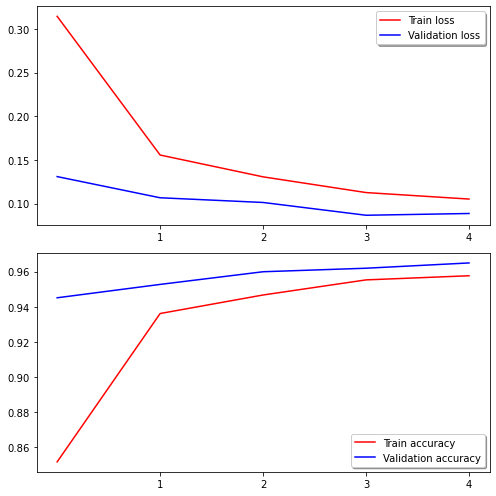

In [43]:
# Plot accuracy and loss curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

ax1.plot(history.history['loss'], color='r', label="Train loss")
ax1.plot(history.history['val_loss'], color='b', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
legend = ax1.legend(loc='best', shadow=True)

ax2.plot(history.history['accuracy'], color='r', label="Train accuracy")
ax2.plot(history.history['val_accuracy'], color='b',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
legend = ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

### Predict on validation data ###

In [44]:
# Prepare Y_val
Y_val = X_val['Category']
# Predict on validation data
Y_pred =  model_mod.predict_generator(validation_generator)

In order to compare predicted and validation data we need to convert predictions (which are probabiliies of classifying an animal as dog or cat, i.e 0,05% prob) into actual class predictions (which are 0 and 1).  
To do it we should define a threshold. Let it be default 0.5.

In [45]:
# Define treshold
threshold = 0.5
# Convert
Y_pred_conv = np.where(Y_pred > threshold, 1,0)

In [46]:
Y_pred_conv[:,0]

array([1, 0, 1, ..., 1, 1, 0])

### Visualize prediction on validation data ###

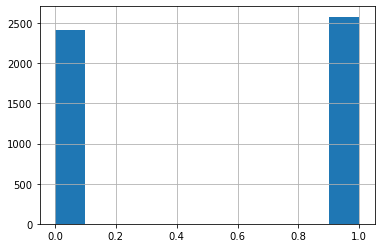

In [47]:
# Plot probability histogram
pd.Series(Y_pred_conv[:,0]).hist()

In order to compute a Confusion matrix we should have our predicted and validation sets in same datatype.

In [48]:
# Check datatypes
Y_pred_conv.dtype

dtype('int64')

In [49]:
Y_val.dtype

dtype('O')

In [50]:
# Convert to int
Y_val_str = Y_val.astype(int)

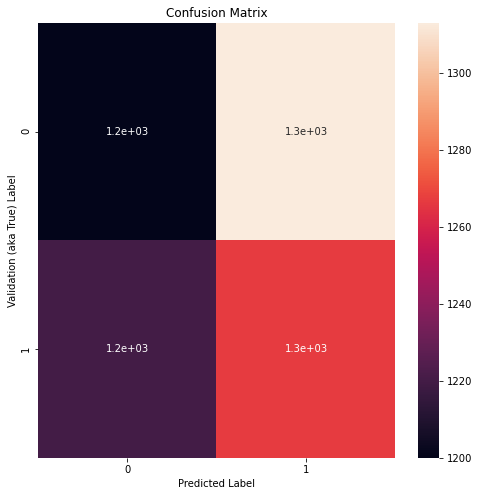

In [51]:
# Compute and plot the Confusion matrix
confusion_mtx = confusion_matrix(Y_val_str, Y_pred_conv) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True)
plt.xlabel("Predicted Label")
plt.ylabel("Validation (aka True) Label")
plt.title("Confusion Matrix")
plt.show()

### Upload test data ###

In [52]:
test_images = os.listdir('/kaggle/working/test_images/test')
X_test = pd.DataFrame({
    'test_imagename': test_images
})
samples = X_test.shape[0]

In [53]:
X_test.count()

test_imagename    12500
dtype: int64

In [54]:
# If we use only 1800 images because of CPU computational reasons:
# X_test_cpu = X_test.sample(n=1800).reset_index()
# X_test_cpu.count()

### Test DataGenerator ###

In [55]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [56]:
test_generator = test_datagen.flow_from_dataframe(
    X_test, 
    "/kaggle/working/test_images/test", 
    x_col='test_imagename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


In [57]:
test_generator

### Predict on test data ###

In [58]:
predict = model_mod.predict_generator(test_generator, steps=np.ceil(samples/batch_size))

In [59]:
predict.shape

(12500, 1)

In [60]:
X_test.shape

(12500, 1)

In [61]:
threshold = 0.5
X_test['Category'] = np.where(predict > threshold, 1,0)

### Save submission results ###

In [127]:
# Save results using competitions format
submit = X_test.copy()
submit['id'] = submit['test_imagename'].str.split('.').str[0]
submit['label'] = submit['Category']
submit.drop(['test_imagename', 'Category'], axis=1, inplace=True)
submit.to_csv('submission_vgg16.csv', index=False)

Text(0.5, 1.0, '(Final answer on test data (Model - VGG16))')

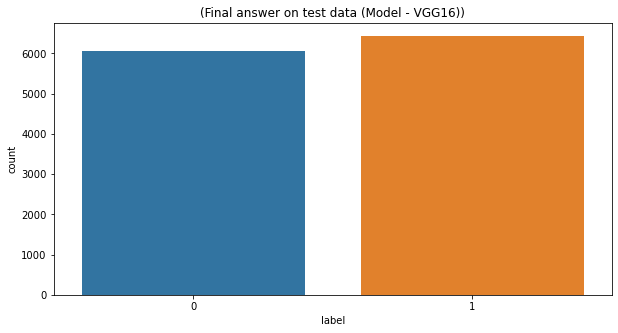

In [63]:
# Check how our answer looks
plt.figure(figsize=(10,5))
sns.countplot(submit['label'])
plt.title("(Final answer on test data (Model - VGG16))")

## Model 2. ResNet-50 ##

### Description ###

ResNet (aka Residual Networks) is a classic neural network used for many computer vision real-world tasks. Was implemented by Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun [9]. This model won ImageNet challenge in 2015. Scheme of net [10]: 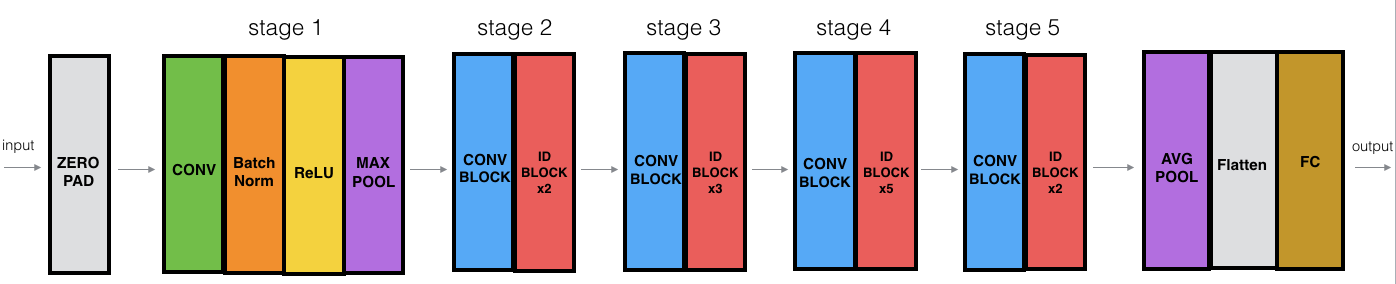

### Implementation ###

We will again use pre-trained network, staying at transfer learning paradigm.
Our steps. Initialize the ResNet-50 model, add an additional last Dense-layer, with softmax activation function and set the first layer of the model to be not trainable, since our model is pre-trained.  

Lets denote a few things about model constants.  
Image size is equal 224 as it was in VGG16 model, number of epochs due to computtional reasons let equal to 5; number of classes is equal to 2, it is self-descriptive; let batch size here be equal to 64.

Download pre-trained weights from Resnet-50 officical datasource on Kaggle [11]. Notice that there are two pre-trained weights files:  
a) ..._tf_kernels.h5;  
b) ..._tf_kernels_NOTOP.h5.  

What are they?   
The _tf_kernels.h5 weights is useful for 'pure' prediction of test image and this prediction will rely completely on ResNet-50 pre-trained weights, it does not expected any training from our side.  

Since we use a Transfer Learning paradigm, we should use models pre-trained weights except its TOP layer, so we will use second (aka notop) weights as initial weight for training new layer using train images.

In [106]:
# Define model constants
# image_size = 224 like in previous model
num_classes = 2
num_epochs = 5
num_batch_size = 64
WEIGHTS_PATH = "../input/resnet-weights-uploaded/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

**Nota Bene**  
Pay attention on weights path. It is manually downloaded from ResNet's Keras Dataset [11] and then manually uploaded into /input directory. First we tryed the most logical way - to attach weights from [11] butdoing so will not work in model definition because of defect mensioned here: https://www.kaggle.com/learn-forum/124381 and https://stackoverflow.com/questions/60119041/failed-to-load-keras-resnet50-model-offline-using-weight-file. So there was nothing better for us than to save the files manually, taking into account the fact that they should be saved forever, since we will need many times (download every time from Imagenet external source seems traffic-wasting unefficiant way). Don't know why, but it worked for one time, so we will skip it and use weights from Imagenet like we did in first model.

In [98]:
# Define model
model_resnet = Sequential()
# Add pre-trained weights
model_resnet.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
# The last dense layer must specify the number of labels (or classes) and activation f-n
model_resnet.add(Dense(num_classes, activation='softmax'))
# Since we load pre-trained model we must specify first layer as non-trainable
model_resnet.layers[0].trainable = True

In [99]:
# Compile model
model_resnet.compile(
    optimizer='sgd', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [100]:
# Print models summary
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


### Train model ###

In [69]:
# Before we begin lets save our train and validation subsets into threir copies
X_train_resnet = X_train
X_val_resnet = X_val
Y_val_resnet = Y_val
Y_train_resnet = animals['Category']

In [70]:
total_X_train_resnet = X_train_resnet.shape[0]
total_X_val_resnet = X_val_resnet.shape[0]

In [71]:
X_train_resnet.head()

,index,Image name,Category
0,18687,cat.8512.jpg,0
1,127,dog.6314.jpg,1
2,24837,dog.4901.jpg,1
3,7286,dog.7558.jpg,1
4,22021,dog.2728.jpg,1


In [72]:
total_X_train_resnet

20000

In [73]:
X_train_resnet.shape

(20000, 3)

In [74]:
X_val_resnet.shape

(5000, 3)

### Train DataGenereator (for ResNet) ###

For model building clarity, lets repeat the process with image generation instead of using from previous step. It is quick. Omit comments, since actions are identical to the previous paragraph.

In [101]:
train_resnet_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [102]:
train_resnet_generator = train_resnet_datagen.flow_from_dataframe(
    X_train_resnet,
    "/kaggle/working/train_images/train",
    x_col='Image name',
    y_col='Category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=num_batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation DataGenereator (for ResNet) ###

In [103]:
validation_resnet_datagen = ImageDataGenerator(
    rescale=1./255
)

In [104]:
validation_resnet_generator = validation_resnet_datagen.flow_from_dataframe(
    X_val_resnet, 
    "/kaggle/working/train_images/train", 
    x_col='Image name',
    y_col='Category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=num_batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [107]:
# Fit the model
history_resnet = model_resnet.fit_generator(
        train_resnet_generator,
        epochs = num_epochs,
        validation_data = validation_resnet_generator,
        validation_steps = total_X_val_resnet//num_batch_size,
        steps_per_epoch = total_X_train_resnet//num_batch_size,
        callbacks = callbacks
)

Epoch 1/5
312/312 [==============================] - 220s 705ms/step - loss: 0.3063 - accuracy: 0.9197 - val_loss: 0.7635 - val_accuracy: 0.5024 - lr: 0.0100
Epoch 2/5
312/312 [==============================] - 222s 711ms/step - loss: 0.0504 - accuracy: 0.9839 - val_loss: 0.6555 - val_accuracy: 0.6150 - lr: 0.0100
Epoch 3/5
312/312 [==============================] - 225s 720ms/step - loss: 0.0165 - accuracy: 0.9952 - val_loss: 0.1320 - val_accuracy: 0.9495 - lr: 0.0100
Epoch 4/5
312/312 [==============================] - 223s 714ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.0822 - val_accuracy: 0.9740 - lr: 0.0100
Epoch 5/5
312/312 [==============================] - 223s 716ms/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.0892 - val_accuracy: 0.9742 - lr: 0.0100


In [108]:
# Leave this output here to outline that we obtain low accuracy when train on 5 epochs and
# first layer trainable = False param
# Epoch 1/5
# 312/312 [==============================] - 190s 611ms/step - loss: 5.4424 - accuracy: 0.5646 - val_loss: 3.1316 - val_accuracy: 0.6012 - lr: 0.0050
# Epoch 2/5
# 312/312 [==============================] - 195s 624ms/step - loss: 5.1490 - accuracy: 0.5693 - val_loss: 5.3533 - val_accuracy: 0.5655 - lr: 0.0050
# Epoch 3/5
# 312/312 [==============================] - ETA: 0s - loss: 5.5350 - accuracy: 0.5592
# Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
# 312/312 [==============================] - 194s 622ms/step - loss: 5.5350 - accuracy: 0.5592 - val_loss: 5.5042 - val_accuracy: 0.5615 - lr: 0.0050
# Epoch 4/5
# 312/312 [==============================] - 193s 617ms/step - loss: 1.8847 - accuracy: 0.6557 - val_loss: 1.7388 - val_accuracy: 0.6354 - lr: 0.0025
# Epoch 5/5
# 312/312 [==============================] - 192s 615ms/step - loss: 2.0500 - accuracy: 0.6221 - val_loss: 5.0342 - val_accuracy: 0.5294 - lr: 0.0025

In [110]:
# Save calculated weigthts
model_resnet.save_weights('model_resnet_wieghts.h5')
model_resnet.save('model_resnet_keras.h5')

### Visualize accuracy and loss curves ###

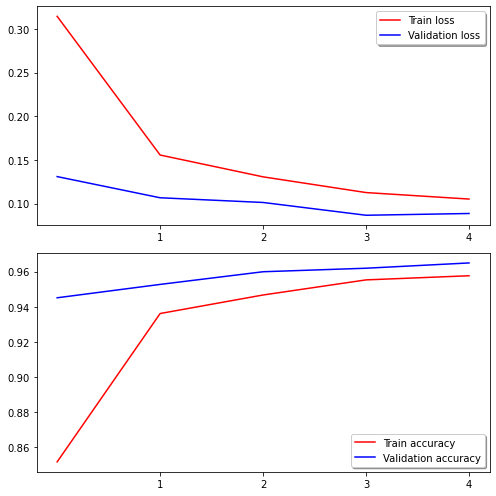

In [112]:
# Plot accuracy and loss curves
fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(7, 7))
history_resnet = history

ax3.plot(history.history['loss'], color='r', label="Train loss")
ax3.plot(history.history['val_loss'], color='b', label="Validation loss")
ax3.set_xticks(np.arange(1, epochs, 1))
legend = ax3.legend(loc='best', shadow=True)

ax4.plot(history.history['accuracy'], color='r', label="Train accuracy")
ax4.plot(history.history['val_accuracy'], color='b',label="Validation accuracy")
ax4.set_xticks(np.arange(1, epochs, 1))
legend = ax4.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

 ### Predict on validation data ###

In [113]:
# Predict on validation X_val_resnet
Y_pred_resnet =  model_resnet.predict_generator(validation_resnet_generator)

In [114]:
# Define treshold
threshold = 0.5
# Convert
Y_pred_conv_res = np.where(Y_pred_resnet > threshold, 1,0)

In [115]:
Y_pred_conv_res[:,0]

array([0, 1, 1, ..., 0, 1, 0])

### Visualize prediction on validation data ###

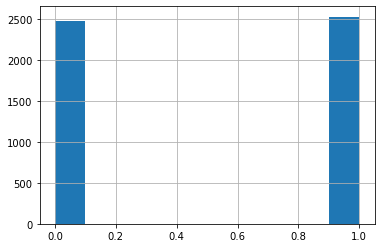

In [116]:
# Plot probability histogram
pd.Series(Y_pred_conv_res[:,0]).hist()

In [117]:
# Prepare Y_val in str dtype
# Convert to int
Y_val_resnet_str = Y_val_resnet.astype(int)

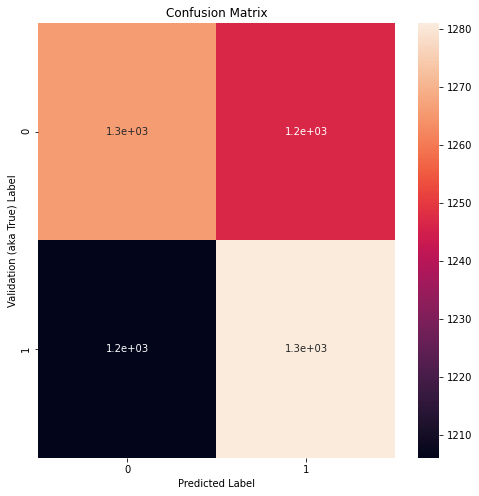

In [118]:
# Compute and plot the Confusion matrix
confusion_mtx_resnet = confusion_matrix(Y_val_resnet_str, Y_pred_conv_res[:,0]) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx_resnet, annot=True)
plt.xlabel("Predicted Label")
plt.ylabel("Validation (aka True) Label")
plt.title("Confusion Matrix")
plt.show()

### Test DataGenerator (for ResNet) ###

In [119]:
# Add X_test_resnet
X_test_resnet = X_test

In [120]:
test_resnet_datagen = ImageDataGenerator(
    rescale=1./255
)

In [121]:
test_resnet_generator = test_resnet_datagen.flow_from_dataframe(
    X_test_resnet, 
    "/kaggle/working/test_images/test", 
    x_col='test_imagename',
    y_col=None,
    class_mode=None,
    batch_size=num_batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


### Predict on test data ###

In [122]:
predict_resnet = model_resnet.predict_generator(test_resnet_generator, steps=np.ceil(samples/num_batch_size))

### Save submission results (Model - ResNet) ###

In [128]:
# Save predictions
submit_resnet = X_test_resnet.copy()
submit_resnet['id'] = submit_resnet['test_imagename'].str.split('.').str[0]
submit_resnet['label'] = submit_resnet['Category']
submit_resnet.drop(['test_imagename', 'Category'], axis=1, inplace=True)
submit_resnet.to_csv('submission_resnet_50.csv', index=False)

Text(0.5, 1.0, '(Final answer on test data (Model - ResNet))')

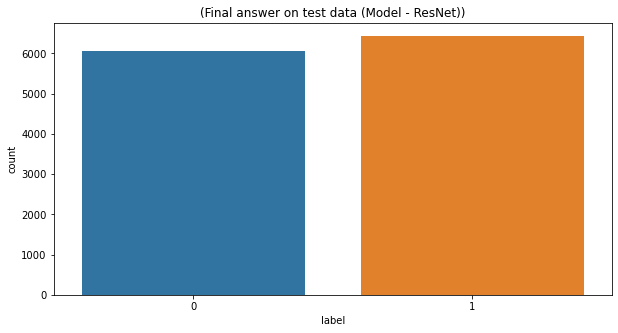

In [129]:
# Check answer
plt.figure(figsize=(10,5))
sns.countplot(submit_resnet['label'])
plt.title("(Final answer on test data (Model - ResNet))")

# Conclusion #
Every great road has great finish. We completed our task of teaching machine how to recognise cats and dogs on pretty photos. We did it twice: using VGG16 and ResNet-50 CNN models. This was in learning purpose. And to be continuous we choosed absolutely different models: one deep and huge in computing and second more complex in structure but less resource-taking.  
So what we obtain?  
1. Model implementation process (as well as data preparation) is very close in both cases. (Remember, we used Transfer learning paradigm - pre-trained models, so we just connected models implementation from Keras library, downloaded pre-trained weights, and specified models few layers, in particular, outputs).
2. Models gave approximately a similar level of accuracy (ResNet-50 gave better result).  
3. CPU and memory usage is very sensitive on old-school PC's like ours (with Core i5 from 2010-s and 4 Gb RAM). Our goal was not trying to benchmark since our models are very famous and probably already have many benchmarks. Therefore, the goal was only to become familiar with the capabilities and implementation of models. And what we can denote? Taking into account paragraphs one and two we can conclude that in all else being equal case it is adecuately to use more quick and modern net at least in order to save our time for new discoveries. Its complicity is not big problem if we use transfer learning concept.

# Literature #

[1] https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7  
[2] https://neurohive.io/en/popular-networks/vgg16/  
[3] https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5  
[4] https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3  
[5] https://arxiv.org/abs/1409.1556  
[6] https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c  
[7] https://keras.io/preprocessing/image/  
[8] https://neurohive.io/en/popular-networks/resnet/  
[9] https://arxiv.org/abs/1512.03385  
[10] https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33  
[11] https://www.kaggle.com/keras/resnet50/  
[12] https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/